In [1]:
import numpy as np
import pandas as pd
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
root_path = 'C:/Users/Dietcokeplz/Desktop/Covid 19 Data'
metadata_path = f'{root_path}/metadata.csv'

In [3]:
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
}, low_memory = False)
meta_df.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [4]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136067 entries, 0 to 136066
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          136067 non-null  object 
 1   sha               58800 non-null   object 
 2   source_x          136067 non-null  object 
 3   title             136037 non-null  object 
 4   doi               106574 non-null  object 
 5   pmcid             64855 non-null   object 
 6   pubmed_id         103307 non-null  object 
 7   license           136067 non-null  object 
 8   abstract          106732 non-null  object 
 9   publish_time      136055 non-null  object 
 10  authors           131064 non-null  object 
 11  journal           129172 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  20591 non-null   object 
 14  arxiv_id          1524 non-null    object 
 15  pdf_json_files    58800 non-null   object 
 16  pmc_json_files    46

In [5]:
# All papers in JSON files location
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

109431

In [6]:
class FileReader:
    
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Read abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Read body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            
    # return paper id, abstract and text body
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

In [7]:
# Test one file

first_row = FileReader(all_json[0])
print(first_row)

0001418189999fea7f7cbe3e82703d71c85a6fe5: Feline infectious peritonitis virus (FIPV) positive cells are present in pyogranulomas and exudates from cats with FIP. These cells belong mainly to the monocyte/macrophage lineage. How these cells su... Feline infectious peritonitis (FIP) is a fatal chronic disease in cats caused by a coronavirus, feline infectious peritonitis virus (FIPV), and characterized by granulomatous lesions formed at the ser...


In [8]:
# Helper function adds break after every words when character length reach to certain amount. 

def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [10]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}

for idx, entry in enumerate(all_json):
    # Percentage of the task finished
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    # The particular row
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    # Fill in the dictionary
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null value
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

In [ ]:
# Save the df to pickle.
df_covid.to_pickle(root_path + '/df_covid.pkl')

In [532]:
df_covid = pd.read_pickle(root_path + '/df_covid.pkl')

In [533]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body

In [534]:
df_covid.head(3)

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,10.1016/j.msard.2020.102139,,How do we protect our 'high-risk' patient popu...,"Vishnevetsky, Anastasia. Levy, Michael",Rethinking high-risk groups in COVID-19,Mult Scler Relat Disord,Not provided.,0,943,486
2,00039b94e6cb7609ecbddee1755314bcfeb77faa,10.1111/j.1365-2249.2004.02415.x,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,"WONG, C K. LAM, C W K. WU, A K L. IP, W K....",Plasma inflammatory cytokines and chemokines<...,Clinical & Experimental Immunology,Severe acute respiratory syndrome (SARS) is a...,179,2822,1103


In [14]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55389 entries, 0 to 55388
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             55389 non-null  object
 1   doi                  53734 non-null  object
 2   abstract             55389 non-null  object
 3   body_text            55389 non-null  object
 4   authors              54203 non-null  object
 5   title                55389 non-null  object
 6   journal              50561 non-null  object
 7   abstract_summary     55389 non-null  object
 8   abstract_word_count  55389 non-null  int64 
 9   body_word_count      55389 non-null  int64 
 10  body_unique_words    55389 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 4.6+ MB


In [15]:
df_covid['abstract'].describe()

count     55389
unique    38989
top            
freq      16197
Name: abstract, dtype: object

In [16]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace = True)

##### It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

In [17]:
df_covid['abstract'].describe()

count     55254
unique    38989
top            
freq      16101
Name: abstract, dtype: object

In [18]:
df_covid['body_text'].describe()

count                              55254
unique                             55249
top       J o u r n a l P r e -p r o o f
freq                                   3
Name: body_text, dtype: object

In [20]:
df_covid.head(3)

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,10.1016/j.msard.2020.102139,,How do we protect our 'high-risk' patient popu...,"Vishnevetsky, Anastasia. Levy, Michael",Rethinking high-risk groups in COVID-19,Mult Scler Relat Disord,Not provided.,0,943,486
2,00039b94e6cb7609ecbddee1755314bcfeb77faa,10.1111/j.1365-2249.2004.02415.x,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,"WONG, C K. LAM, C W K. WU, A K L. IP, W K....",Plasma inflammatory cytokines and chemokines<...,Clinical & Experimental Immunology,Severe acute respiratory syndrome (SARS) is a...,179,2822,1103


In [21]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,55254.000000,55254.000000,55254.000000
mean,157.341315,4724.854400,1397.384026
std,188.092130,9997.252749,1632.943670
min,0.000000,1.000000,1.000000
25%,0.000000,1959.000000,789.000000
50%,150.000000,3321.000000,1154.000000
75%,233.000000,5099.000000,1597.000000
max,7415.000000,279623.000000,38298.000000


In [22]:
# Remove rows that have nan values
df = df_covid.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49060 entries, 0 to 55387
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             49060 non-null  object
 1   doi                  49060 non-null  object
 2   abstract             49060 non-null  object
 3   body_text            49060 non-null  object
 4   authors              49060 non-null  object
 5   title                49060 non-null  object
 6   journal              49060 non-null  object
 7   abstract_summary     49060 non-null  object
 8   abstract_word_count  49060 non-null  int64 
 9   body_word_count      49060 non-null  int64 
 10  body_unique_words    49060 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 4.5+ MB


In [23]:
# take 10000 sample papers to speed up the calculation
df = df.sample(10000, random_state=42)

In [106]:
# Detect language for every paper

from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through every text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    # Set default language as English
    lang = "en"
    try:
        # Case when number of words greater than 50
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        # Case when number of words between 0 and 50
        elif len(text) > 0:
            lang = detect(" ".join(text))
#             lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

In [114]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 10000

{'cy': 1,
 'de': 143,
 'en': 9684,
 'es': 60,
 'fr': 79,
 'it': 8,
 'nl': 21,
 'pt': 3,
 'sq': 1}


In [125]:
# sort the dictionary by key
sorted_list = sorted(languages_dict.items(), key = lambda kv:(kv[0]))
language_list = list(map(lambda x: x[0], sorted_list))
language_count_list = list(map(lambda x: x[1], sorted_list))

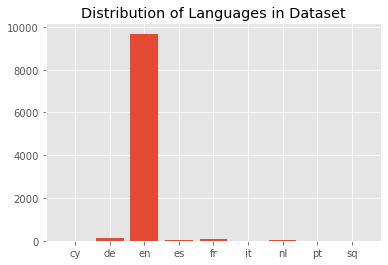

In [129]:
# paper distribution by language

df['language'] = languages
plt.bar(range(len(languages_dict)), language_count_list, align='center')
plt.xticks(range(len(languages_dict)), language_list)
plt.title("Distribution of Languages in Dataset")
plt.show()

In [131]:
# Filter for articles that are written in English

df = df[df['language'] == 'en']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9684 entries, 11701 to 41293
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             9684 non-null   object
 1   doi                  9684 non-null   object
 2   abstract             9684 non-null   object
 3   body_text            9684 non-null   object
 4   authors              9684 non-null   object
 5   title                9684 non-null   object
 6   journal              9684 non-null   object
 7   abstract_summary     9684 non-null   object
 8   abstract_word_count  9684 non-null   int64 
 9   body_word_count      9684 non-null   int64 
 10  body_unique_words    9684 non-null   int64 
 11  language             9684 non-null   object
dtypes: int64(3), object(9)
memory usage: 983.5+ KB


In [111]:
import seaborn as sns

count      9684.000000
mean       4063.820735
std        4114.913538
min           3.000000
25%        1966.750000
50%        3340.500000
75%        5062.000000
max      140853.000000
Name: body_word_count, dtype: float64

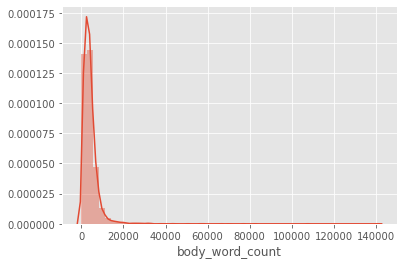

In [112]:
# Distribution of body word count
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     9684.000000
mean      1294.252169
std        855.737587
min          3.000000
25%        802.750000
50%       1165.000000
75%       1600.000000
max      19746.000000
Name: body_unique_words, dtype: float64

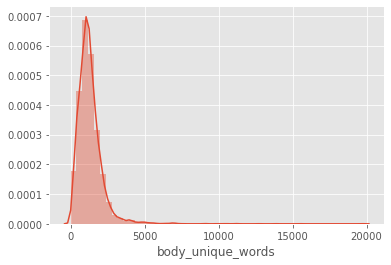

In [113]:
# distribution of unique word count in paper body
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

In [4]:
# Where NLP Starts
# text pre-processing

import re
import nltk
import spacy
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

punctuations = string.punctuation
stop_words = set(stopwords.words('english'))

In [137]:
# default stop words

stop_words = list(stop_words)

In [141]:
# custom stop words in regard to covid-19

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

In [145]:
# Add custom stop words to the default stop words list
for my_stop_word in custom_stop_words:
    if my_stop_word not in stop_words:
        stop_words.append(my_stop_word)

In [5]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
import string

# tokenize, remove punctuation and stops words, then lemmatizate the words
def preprocess(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word

    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words

    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

#     porter = PorterStemmer()
#     stemmed = [porter.stem(word) for word in words]

    # Use lemmatization here instead of stemming to keep the word being a word
    lemmatizer = WordNetLemmatizer()   
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    
    lemmatized = " ".join([i for i in tokens])

    return lemmatized

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dietcokeplz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Tokens

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(preprocess)

In [ ]:
df["tokens"] = df["processed_text"].apply(lambda x: word_tokenize(x))

In [ ]:
# Tokens_2 (Make bigram and trigram)

In [6]:
# %%time

# Gensim version of remove punctuation
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentence):
    
    return gensim.utils.simple_preprocess(str(sentence), deacc=True)  # deacc=True removes punctuations


Wall time: 0 ns


In [36]:
tqdm.pandas()
df['tokens_2'] = df["body_text"].progress_apply(sent_to_words)

C:\Users\Dietcokeplz\.conda\envs\tensorflow\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████████████████████████████████████████████████████| 9684/9684 [01:50<00:00, 87.48it/s]


In [322]:
df.head(3)

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,tokens,tokens_2,tokens_3
11701,3649c1c9ea7df5bf33507851cf584a6fff966ce8,10.1016/j.diabres.2020.108195,,Between the end of the second and the beginnin...,"Gentile, Sandro. Mambro, Andrea. Strollo,<b...","Parallel epidemics, or nearly so: certainties...",Diabetes Res Clin Pract,Not provided.,0,2488,1160,en,between the end of the second and the beginnin...,"[between, the, end, of, the, second, and, the,...","[between, the, end, of, the, second, and, the,...","[end, second, begin, follow, century, philosop..."
54060,f9fa9e916bd5a44688510947a0980ba20607ae56,10.1007/s10096-006-0222-z,The Centers for Disease Control and Prevention...,ratory-confirmed SARS (2003) were compared wit...,"Lee, N.. Rainer, T. H.. Ip, M.. Zee, B.. ...",Role of laboratory variables in<br>differenti...,Eur J Clin Microbiol Infect Dis,The Centers for Disease Control and Preventio...,67,3099,1121,en,ratory-confirmed sars ( 2003 ) were compared w...,"[ratory-confirmed, sars, (, 2003, ), were, com...","[ratory, confirmed, sars, were, compared, with...","[confirm, compare, consecutive, patient, hospi..."
16391,4bae83e2441c3738d96e49c21c9be0a4c85b4a92,10.4142/jvs.2013.14.1.53,The protective efficacy of DNA plasmids encodi...,Avian infectious bronchitis (IB) is a major di...,"Yan, Fang. Zhao, Yujun. Hu, Yongting. Qiu,...",Protection of chickens against infectious<br>...,J Vet Sci,The protective efficacy of DNA plasmids<br>en...,179,2996,1003,en,avian infectious bronchitis ( ib ) is a major ...,"[avian, infectious, bronchitis, (, ib, ), is, ...","[avian, infectious, bronchitis, ib, is, major,...","[infectious, major, disease, worldwide, diseas..."


In [323]:
data_words = list(df['tokens_2'])

In [324]:
from gensim.models.phrases import Phrases, Phraser

In [325]:
# Train bigram, trigram model
bigram = Phrases(data_words, min_count = 5, threshold = 100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold = 100)

In [326]:
# Export bigram/trigram model 
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [319]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [328]:
import spacy
import en_core_web_sm

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [43]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [44]:
df['tokens_3'] = data_lemmatized

In [56]:
df.to_pickle(root_path + '/df_covid_processed.pkl')

In [8]:
df = pd.read_pickle(root_path + '/df_covid_processed.pkl')

In [10]:
import gensim

In [33]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(df['tokens_3'])
dictionary.filter_extremes(no_below=3, no_above=0.3, keep_n=20000)

In [34]:
# Use to preprocess text representations
# doc2bow the returned tuple represents (TOKENid, TOKENcount)
gs_preprocessed_texts = [dictionary.doc2bow(text) for text in df['tokens_3']]

In [35]:
# Train model
NUM_TOPICS = 20

lda = gensim.models.LdaModel(gs_preprocessed_texts, id2word=dictionary, 
                             num_topics=NUM_TOPICS, random_state=5, alpha=0.1, eval_every=5,
                             gamma_threshold=1e-6)

In [36]:
# list all topics and their most salient terms
lda.show_topics(NUM_TOPICS)

[(0,
  '0.012*"covid" + 0.007*"therapy" + 0.004*"diagnosis" + 0.004*"recommend" + 0.004*"surgery" + 0.004*"pressure" + 0.004*"trial" + 0.004*"management" + 0.004*"complication" + 0.003*"child"'),
 (1,
  '0.005*"social" + 0.005*"pandemic" + 0.004*"people" + 0.004*"issue" + 0.004*"crisis" + 0.004*"experience" + 0.004*"disaster" + 0.004*"resource" + 0.004*"government" + 0.004*"practice"'),
 (2,
  '0.021*"influenza" + 0.009*"vaccination" + 0.009*"dog" + 0.008*"child" + 0.006*"bird" + 0.006*"adult" + 0.005*"tract" + 0.005*"ferret" + 0.005*"illness" + 0.004*"sign"'),
 (3,
  '0.026*"cd" + 0.021*"mouse" + 0.018*"compound" + 0.009*"antiviral" + 0.009*"plant" + 0.007*"extract" + 0.007*"lung" + 0.005*"rat" + 0.004*"inhibition" + 0.004*"inhibit"'),
 (4,
  '0.013*"calf" + 0.010*"cat" + 0.010*"lung" + 0.006*"lesion" + 0.006*"sign" + 0.005*"diarrhea" + 0.005*"pulmonary" + 0.004*"pressure" + 0.003*"milk" + 0.003*"cattle"'),
 (5,
  '0.013*"ace" + 0.009*"antigen" + 0.009*"ad" + 0.009*"epitope" + 0.008*"

In [62]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=df['tokens_3'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5659267319317828


In [63]:
# Tuning Hyper-parameter
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda = gensim.models.LdaModel(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=k, 
                                 random_state=5,
                                 alpha=a,
                                 eval_every=b,
                                 gamma_threshold=1e-6
                                )
    
    coherence_model_lda = CoherenceModel(model=lda, texts=df['tokens_3'], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [107]:
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 10
max_topics = 25
step_size = 5
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.05, 0.3, 0.05))
# alpha.append('symmetric')
# alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(2, 11, 3))
# beta.append('symmetric')
# Validation sets
num_of_docs = len(gs_preprocessed_texts)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(gs_preprocessed_texts, num_of_docs*0.75),
               gs_preprocessed_texts]
corpus_title = [#'75% Corpus', 
                '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'eval_every': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=45)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['eval_every'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [72]:
Results = pd.DataFrame(model_results)

In [79]:
# sort the results by coherence score in descending order
sorted_Results = Results.sort_values(by = 'Coherence', ascending = False)

In [542]:
sorted_Results.head(10)

,Validation_Set,Topics,Alpha,eval_every,Coherence
18,100% Corpus,15,0.10,2,0.581537
15,100% Corpus,15,0.05,2,0.581038
27,100% Corpus,15,0.25,2,0.580872
29,100% Corpus,15,0.25,8,0.580693
28,100% Corpus,15,0.25,5,0.580693
21,100% Corpus,15,0.15,2,0.579990
24,100% Corpus,15,0.20,2,0.579990
17,100% Corpus,15,0.05,8,0.578876
16,100% Corpus,15,0.05,5,0.578876
23,100% Corpus,15,0.15,8,0.578385


In [94]:
print('Highest Coherence Score Results:\n\n')
print(sorted_Results.iloc[0])

Highest Coherence Score Results:


Validation_Set    100% Corpus
Topics                     15
Alpha                     0.1
eval_every                  2
Coherence            0.581537
Name: 18, dtype: object


In [95]:
# Train the model using parameters of highest coherence score
NUM_TOPICS = 15

lda = gensim.models.LdaModel(gs_preprocessed_texts, id2word=dictionary, 
                             num_topics=NUM_TOPICS, random_state=5, alpha=0.1, eval_every=2,
                             gamma_threshold=1e-6)

In [235]:
# store top 3 topics(if applicable) of every paper
Group_1 = []
Group_2 = []
Group_3 = []

In [236]:
# take second element for sort
def takeSecond(elem):
    return elem[1]


for text in gs_preprocessed_texts:
    clusters = lda[text]
    
    clusters.sort(key=takeSecond, reverse = True)
    
    try:
        Group_1.append(lda[text][0][0])
    except:
        Group_1.append(np.nan)
    
    try:
        Group_2.append(lda[text][1][0])
    except:
        Group_2.append(np.nan)
        
    try:
        Group_3.append(lda[text][2][0])
    except:
        Group_3.append(np.nan)

In [98]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [530]:
# Visualize the topic distribution and their most salient terms
viz_data = pyLDAvis.gensim.prepare(lda, gs_preprocessed_texts, dictionary)

In [516]:
# viz_data

In [537]:
# Create dataframe with paper id, title and top 3 topics for every paper
article_mat = df[['paper_id', 'title']].reset_index().drop(['index'], axis = 1)

In [538]:
article_mat['Group_1'] = Group_1
article_mat['Group_2'] = Group_2
article_mat['Group_3'] = Group_3

In [539]:
article_mat.head(3)

,paper_id,title,Group_1,Group_2,Group_3
0,3649c1c9ea7df5bf33507851cf584a6fff966ce8,"Parallel epidemics, or nearly so: certainties...",0,1.0,3.0
1,f9fa9e916bd5a44688510947a0980ba20607ae56,Role of laboratory variables in<br>differenti...,9,NaN,NaN
2,4bae83e2441c3738d96e49c21c9be0a4c85b4a92,Protection of chickens against infectious<br>...,3,12.0,NaN


In [266]:
article_Group_1 = article_mat[['paper_id', 'Group_1']]
article_Group_2 = article_mat[['paper_id', 'Group_2']]
article_Group_3 = article_mat[['paper_id', 'Group_3']]

article_Group_1 = article_Group_1.rename(columns={"paper_id": "paper_id", "Group_1": "Group"})
article_Group_2 = article_Group_2.rename(columns={"paper_id": "paper_id", "Group_2": "Group"})
article_Group_3 = article_Group_3.rename(columns={"paper_id": "paper_id", "Group_3": "Group"})

article_Group_2 = article_Group_2[article_Group_2['Group'] != 'NaN']
article_Group_3 = article_Group_3[article_Group_3['Group'] != 'NaN']

C:\Users\Dietcokeplz\.conda\envs\tensorflow\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [267]:
article_mat = article_Group_1.append(article_Group_2, ignore_index = True)
article_mat = article_mat.append(article_Group_3, ignore_index = True)

In [500]:
# remove duplicated paper_ids with same categories
article_mat.drop_duplicates(inplace = True)

In [501]:
category_mat = article_mat.groupby(['paper_id', 'Group'])['Group'].count().unstack()

In [540]:
# If a paper has interacted with a topic, then place a 1 where the paper-row meets for that topic-column
# If a topic does not show as one of the top 3 topics of a paper, then place a 0 where the paper-row meets for that topic-column
category_mat.head(3)

Group,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
paper_id,,,,,,,,,,,,,,,
0003793cf9e709bc2b9d0c8111186f78fb73fc04,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0004774b55eb0dad880aba9b572efe362660c5e0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00060fb61742ff60e4e3ba4648c74a34cfe9560d,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [503]:
category_mat = category_mat.fillna(0)

In [541]:
category_mat.head(3)

Group,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
paper_id,,,,,,,,,,,,,,,
0003793cf9e709bc2b9d0c8111186f78fb73fc04,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0004774b55eb0dad880aba9b572efe362660c5e0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00060fb61742ff60e4e3ba4648c74a34cfe9560d,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [520]:
def find_topics(lda_model, text):
    
    text = sent_to_words(text)
    
    # Remove Stop Words
    text_nostops = remove_stopwords([text])

    # Form Bigrams
    text_bigram = make_bigrams(text_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    nlp = en_core_web_sm.load(disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    text_lemmatized = lemmatization(text_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    processed_text = dictionary.doc2bow(text_lemmatized[0])
    
    result = lda_model[processed_text]
    
    result.sort(key=takeSecond, reverse = True)
    
    # Create matrix of 15 zeros to store probability
    result_mat = np.zeros(15)
    count = 0
    
    for topic in result:
        
        result_mat[topic[0]] = topic[1]
        count += 1
        
        if count >= 3:
            break
    
    return [result, result_mat]

In [506]:
# Calculate similarity between the unseed text and every paper else using matrix factorization

def find_similarities(category_mat, topics):
    
    rows = category_mat.shape[0]
    
    paper_ids = []
    similarities = []
    
    for n in range(0, rows):
        
        paper_id = category_mat.iloc[n].name
        
        similarity = np.dot(category_mat.iloc[n].values, topics.T)
        
        paper_ids.append(paper_id)
        similarities.append(similarity)
        
    return article_ids, similarities


##### Let's try a paper from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7270045/
##### Save the first a few paragraphs as the text to be analyzed

In [507]:
# Sample unseen text
sample_text = 'As of March 12, 2020, coronavirus disease 2019 (COVID-19) has been confirmed in 125 048 people worldwide, carrying a mortality of approximately 3·7%,1 compared with a mortality rate of less than 1% from influenza. There is an urgent need for effective treatment. Current focus has been on the development of novel therapeutics, including antivirals and vaccines. Accumulating evidence suggests that a subgroup of patients with severe COVID-19 might have a cytokine storm syndrome. We recommend identification and treatment of hyperinflammation using existing, approved therapies with proven safety profiles to address the immediate need to reduce the rising mortality. Current management of COVID-19 is supportive, and respiratory failure from acute respiratory distress syndrome (ARDS) is the leading cause of mortality.2 Secondary haemophagocytic lymphohistiocytosis (sHLH) is an under-recognised, hyperinflammatory syndrome characterised by a fulminant and fatal hypercytokinaemia with multiorgan failure. In adults, sHLH is most commonly triggered by viral infections3 and occurs in 3·7–4·3% of sepsis cases.4 Cardinal features of sHLH include unremitting fever, cytopenias, and hyperferritinaemia; pulmonary involvement (including ARDS) occurs in approximately 50% of patients.5 A cytokine profile resembling sHLH is associated with COVID-19 disease severity, characterised by increased interleukin (IL)-2, IL-7, granulocyte-colony stimulating factor, interferon-γ inducible protein 10, monocyte chemoattractant protein 1, macrophage inflammatory protein 1-α, and tumour necrosis factor-α.6 Predictors of fatality from a recent retrospective, multicentre study of 150 confirmed COVID-19 cases in Wuhan, China, included elevated ferritin (mean 1297·6 ng/ml in non-survivors vs 614·0 ng/ml in survivors; p<0·001) and IL-6 (p<0·0001),2 suggesting that mortality might be due to virally driven hyperinflammation. As during previous pandemics (severe acute respiratory syndrome and Middle East respiratory syndrome), corticosteroids are not routinely recommended and might exacerbate COVID-19-associated lung injury.7 However, in hyperinflammation, immunosuppression is likely to be beneficial. Re-analysis of data from a phase 3 randomised controlled trial of IL-1 blockade (anakinra) in sepsis, showed significant survival benefit in patients with hyperinflammation, without increased adverse events.8 A multicentre, randomised controlled trial of tocilizumab (IL-6 receptor blockade, licensed for cytokine release syndrome), has been approved in patients with COVID-19 pneumonia and elevated IL-6 in China (ChiCTR2000029765).9 Janus kinase (JAK) inhibition could affect both inflammation and cellular viral entry in COVID-19.10 All patients with severe COVID-19 should be screened for hyperinflammation using laboratory trends (eg, increasing ferritin, decreasing platelet counts, or erythrocyte sedimentation rate) and the HScore11 (table ) to identify the subgroup of patients for whom immunosuppression could improve mortality. Therapeutic options include steroids, intravenous immunoglobulin, selective cytokine blockade (eg, anakinra or tocilizumab) and JAK inhibition.'

In [521]:
# Find the most similar paper ids and the similarities given the categories generated by find_topics function
paper_ids, similarities = find_similarities(category_mat, find_topics(lda, sample_text)[1])

In [509]:
# Create the dataframe and sort by similarity
similarity_mat = pd.DataFrame({'paper_id': paper_ids, 'similarity': similarities}).sort_values(by = ['similarity'], ascending = False)

In [510]:
# Top 10 similar papers
top_10 = similarity_mat.head(10)
top_10

,paper_id,similarity
343,096dd60c52a31f8a7dacbc5cbbe0d5f8cb1ace26,0.983216
9607,fe14106f9f3d2b3b6d8ea619cfcc4363148dc84b,0.983216
2944,4d2e83e8e3bc27a0f3fd437ba8ad049aaeee3d99,0.983216
5778,99df1cd5d45940408ee8595fa5826dc3ba37413e,0.983216
4011,69f86b52667bfbb3fc2a6e8f19769634268d6faf,0.983216
6270,a5e0a0ed5bd96d5d8bda79b3b77b68ade21eaee0,0.983216
1665,2bb7f643e85e47f4403a39503dc97e71d46d8baa,0.983216
1667,2bc32d5df1c0d8656799d0cc8355be8b5aa4aa0d,0.983216
3488,5c8c10da93fecd1d2a2a75fdac68d479a1d6135e,0.983216
5800,9a696d2ecdf3d687c5fbb527f83b573904ed2867,0.983216


In [511]:
top_10_ids = list(top_10['paper_id'])

In [543]:
recommendations = df[df['paper_id'].apply(lambda x: x in top_10_ids)][['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal']]

In [544]:
# top 10 most relevant papers
top_10.merge(recommendations, on = ['paper_id'])

,paper_id,similarity,abstract,body_text,authors,title,journal
0,096dd60c52a31f8a7dacbc5cbbe0d5f8cb1ace26,0.983216,Pulmonary complications are major causes of mo...,Abstract Pulmonary complications are major cau...,"Fazekas, T.. Eickhoff, P.. Lawitschka, A.. ...",Exhaled nitric oxide and pulmonary<br>complic...,Eur J Pediatr
1,fe14106f9f3d2b3b6d8ea619cfcc4363148dc84b,0.983216,Background: The development of the innate and ...,The development of an adaptive immune response...,"Balasch, Monica. Fort, Maria. Taylor, Lucas...",Immune response development after<br>vaccinat...,Porcine Health Manag
2,4d2e83e8e3bc27a0f3fd437ba8ad049aaeee3d99,0.983216,Acute respiratory failure; Immunosuppression; ...,Molecular detection of respiratory viruses in ...,"Schnell, David. Legoff, Jérôme. Mariotte,<b...",Molecular detection of respiratory viruses in...,Respir Med
3,99df1cd5d45940408ee8595fa5826dc3ba37413e,0.983216,Purpose of Review This article reviews the new...,Critically ill trauma patients are at high ris...,"Schellenberg, Morgan. Inaba, Kenji",Pneumonia in Trauma Patients,Curr Trauma Rep
4,69f86b52667bfbb3fc2a6e8f19769634268d6faf,0.983216,Kawasaki disease (KD) is a systemic vasculitis...,development of coronary artery lesions (CAL) i...,"Lin, Li-Yan. Yang, Tsung-Hsien. Lin,<br>Yin...",Comparison of the Laboratory Data Between<br>...,Pediatr Cardiol
5,a5e0a0ed5bd96d5d8bda79b3b77b68ade21eaee0,0.983216,Viruses are the predominant infectious cause o...,Infections have been recognized to be a cause ...,"Huckabee, Matthew M. Peebles, R Stokes",Novel concepts in virally induced asthma,Clin Mol Allergy
6,2bb7f643e85e47f4403a39503dc97e71d46d8baa,0.983216,,The infection mediated by SARS-CoV-2 (severe a...,"Emmi, Giacomo. Bettiol, Alessandra. <br>Matt...",SARS-CoV-2 infection among patients with<br>s...,Autoimmun Rev
7,2bc32d5df1c0d8656799d0cc8355be8b5aa4aa0d,0.983216,Antithymocyte globulin (ATG) preparations in a...,Among the factors influencing engraftment afte...,"Zimmermann, SY. Klingebiel, T. Koehl, U. <b...",Tecelac as antithymocyte globulin in<br>condi...,Bone Marrow Transplant
8,5c8c10da93fecd1d2a2a75fdac68d479a1d6135e,0.983216,Background. Pneumonia represents an important ...,Pneumonia is the single greatest cause of deat...,"Donà, Daniele. Luise, Dora. Da Dalt, Livian...",Treatment of Community-Acquired Pneumonia:<br...,Int J Pediatr
9,9a696d2ecdf3d687c5fbb527f83b573904ed2867,0.983216,Intravenous brentuximab vedotin (ADCETRIS Ò ) ...,Abstract Intravenous brentuximab vedotin (ADCE...,"Scott, Lesley J.",Brentuximab Vedotin: A Review in<br>CD30-Posi...,Drugs


In [522]:
related_topics = find_topics(lda, sample_text)[0]

In [523]:
# relevant topics
related_topics

[(9, 0.61999375), (13, 0.3632218)]

In [548]:
pyLDAvis.display(viz_data)